In [1]:
import numba
from numba import njit
import functions_new_jit as func
import importlib
importlib.reload(func)

##########################################################################################################################################

import numpy as np
import matplotlib.pyplot as plt
import random as rd
from IPython.display import clear_output

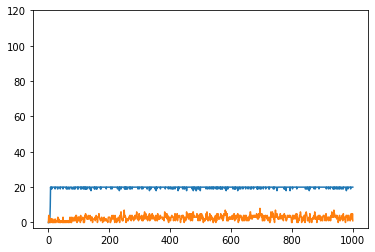

In [2]:
N = 120
average = 45
deviaition = 20

sector0_size = 20
sector1_size = 100
agents0 = func.create_agents(N,average,deviaition)

system = func.System(agents0, sector0_size, sector1_size)

steps = 1000

migration_probability = 0.01

progression = func.simulate_riot_sectors_migration_exit(system, steps, 0.01)


plt.figure()
plt.plot(progression[0])
plt.plot(progression[1])
plt.ylim(-3,N)
plt.show()

In [3]:
def zas4(sector0_size, mig_prob):
    N = 100 + sector0_size
    averages_sample = np.arange(0,100)  # average value of the normal distribution
    deviations = np.arange(0,100)       # standard deviations of the normal distribution

    sector1_size = 100

    steps = 100
    simulations = 100

    heat_map_0 = np.zeros((100,100))
    heat_map_1 = np.zeros((100,100))
    heat_map_total = np.zeros((100,100))

    for k in numba.prange(len(averages_sample)):
        average = averages_sample[k]
        
        for i in numba.prange(len(deviations)):         # a set of simulations per standard deviation value
            deviation = deviations[i]
            average_size_0 = 0
            average_size_1 = 0
            average_size_total = 0

            for j in numba.prange(simulations):   # riot simulation
                agents = func.create_agents(N,average,deviation)
                system = func.System(agents, sector0_size, sector1_size)
                final = func.simulate_riot_sectors_migration_exit(system, steps, mig_prob)
                average_size_0 += final[0][-1]
                average_size_1 += final[1][-1]
                average_size_total += final[0][-1] + final[1][-1]

            average_size_0 = average_size_0/simulations
            average_size_1 = average_size_1/simulations
            average_size_total = average_size_total/simulations
            heat_map_0[i][k] = average_size_0
            heat_map_1[i][k] = average_size_1
            heat_map_total[i][k] = average_size_total

    return heat_map_0, heat_map_1, heat_map_total

In [6]:
sizes = [30, 50, 70, 90]
probs = [0.01, 0.1, 0.3, 0.5, 0.7, 0.9]
textos = ["001", "01", "03", "05", "07", "09"]

for sector0_size in sizes:
    for j in range(len(probs)):
        print(sector0_size, probs[j])
        migprob = probs[j]
        migprobtexto = textos[j]
        h0, h1, h2 = zas4(sector0_size, migprob)

        f1 = open("simulate_riot_sectors_migration_exit_" + str(sector0_size) + "_" + migprobtexto + "_difsizes_0.txt", "w")
        f2 = open("simulate_riot_sectors_migration_exit_" + str(sector0_size) + "_" + migprobtexto + "_difsizes_1.txt", "w")
        f3 = open("simulate_riot_sectors_migration_exit_" + str(sector0_size) + "_" + migprobtexto + "_difsizes_total.txt", "w")

        for i in range(100):
            for j in range(100):
                f1.write(str(i) + " " + str(j) + " " + str(h0[i][j]) + "\n")
                f2.write(str(i) + " " + str(j) + " " + str(h1[i][j]) + "\n")
                f3.write(str(i) + " " + str(j) + " " + str(h2[i][j]) + "\n")
        f1.close()
        f2.close()
        f3.close()

30 0.01
30 0.1
30 0.3
30 0.5
30 0.7
30 0.9
50 0.01
50 0.1
50 0.3
50 0.5
50 0.7
50 0.9
70 0.01
70 0.1
70 0.3
70 0.5
70 0.7
70 0.9
90 0.01
90 0.1
90 0.3
90 0.5
90 0.7
90 0.9


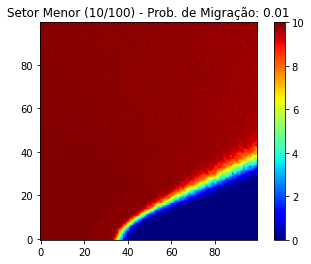

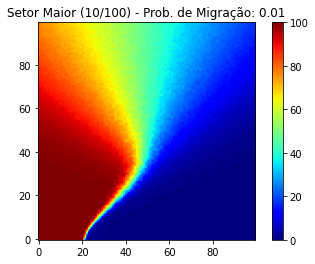

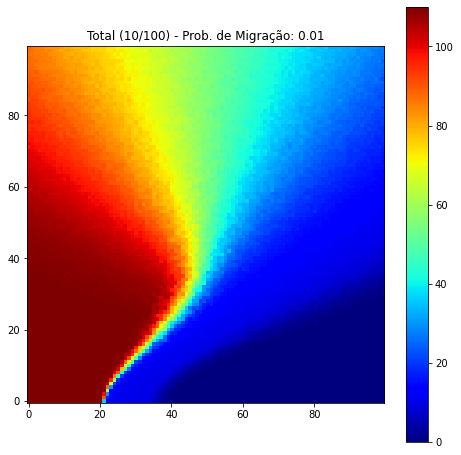

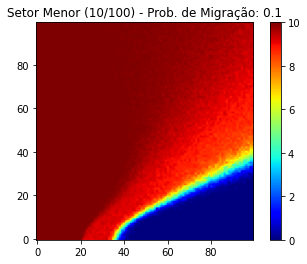

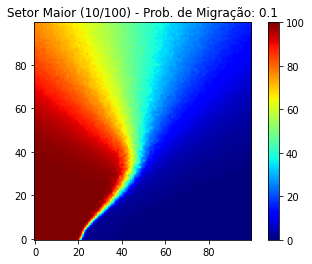

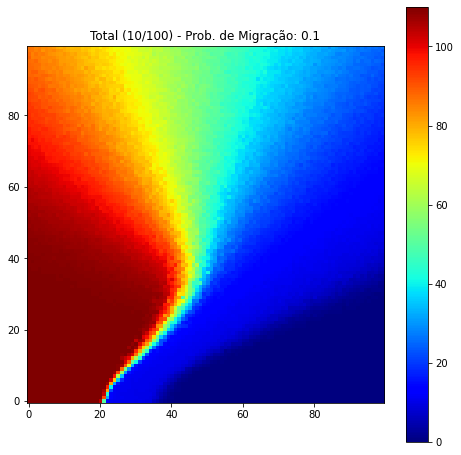

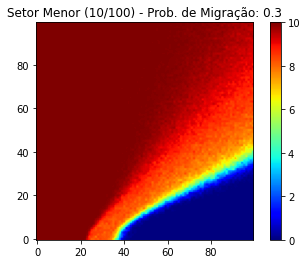

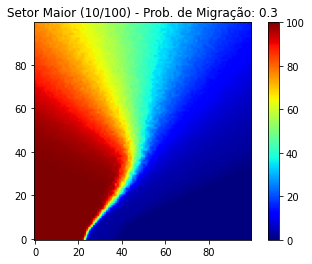

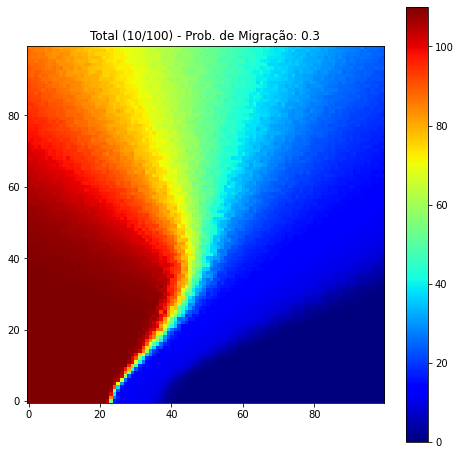

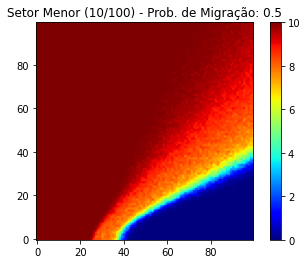

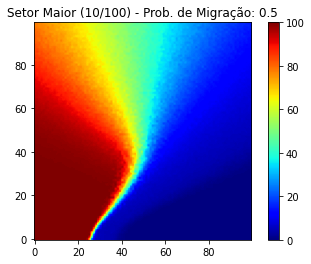

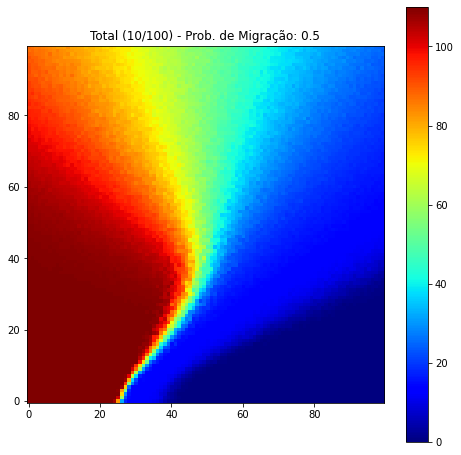

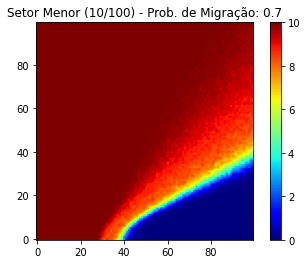

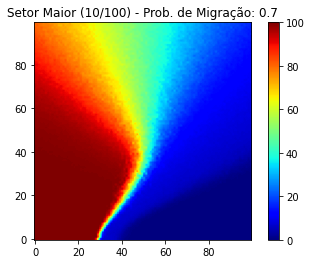

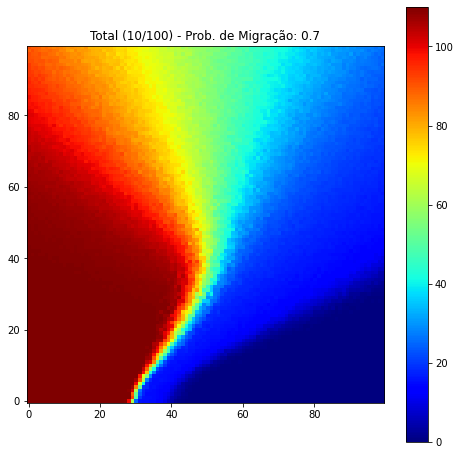

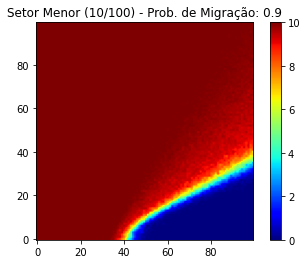

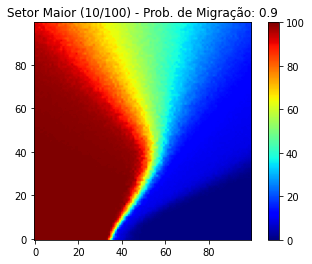

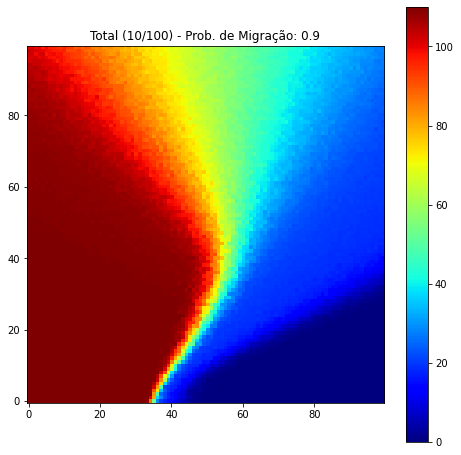

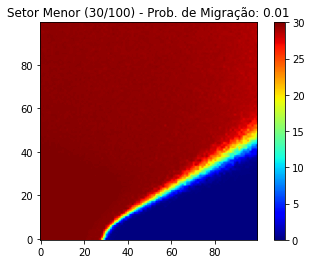

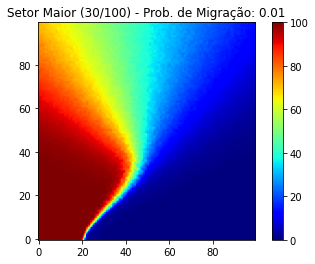

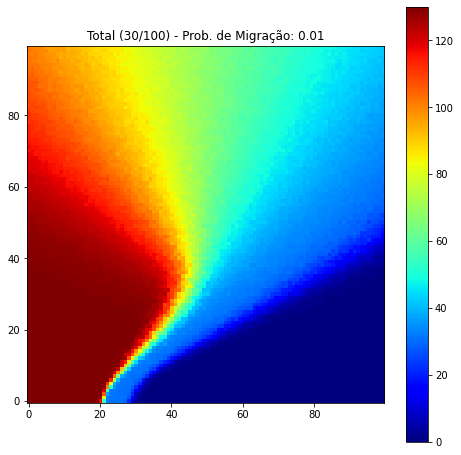

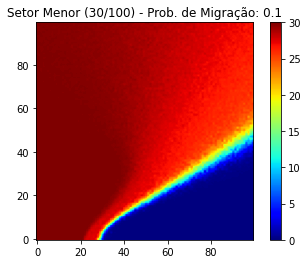

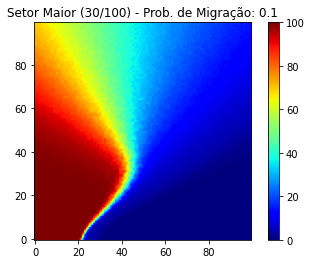

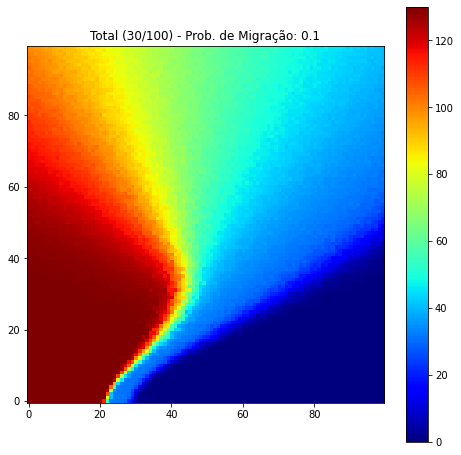

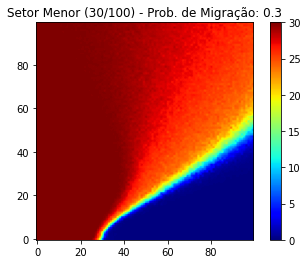

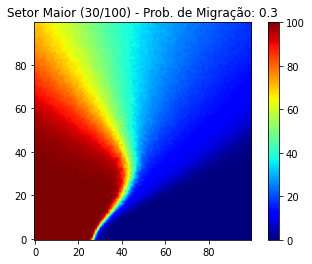

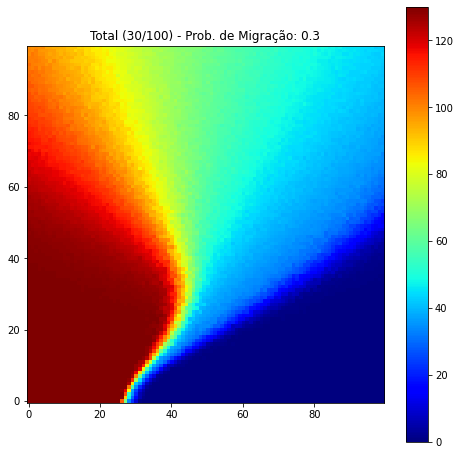

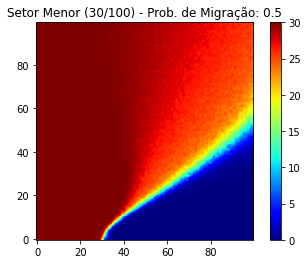

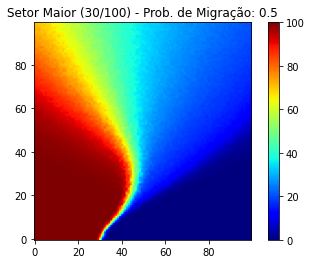

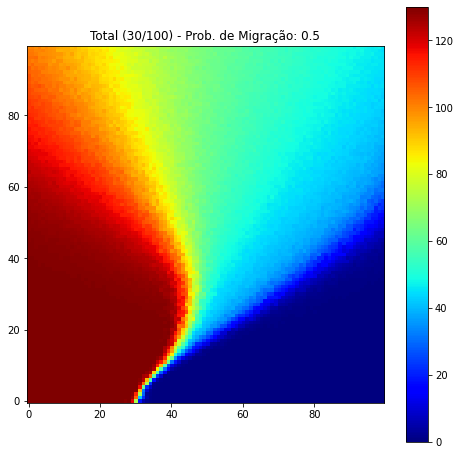

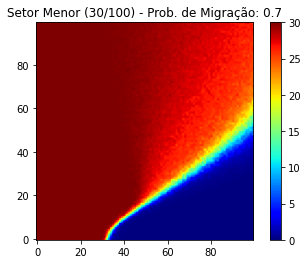

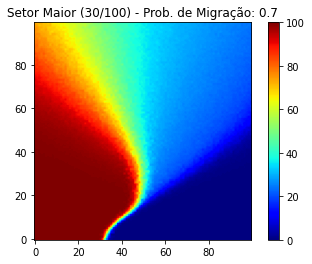

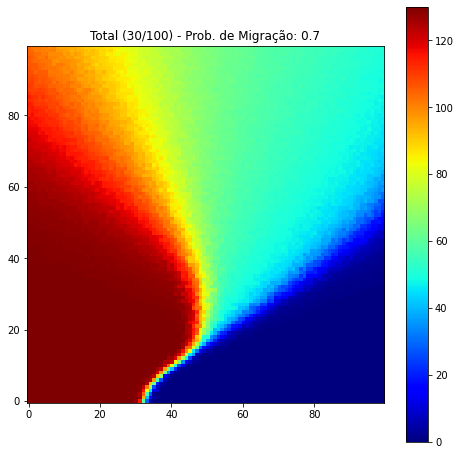

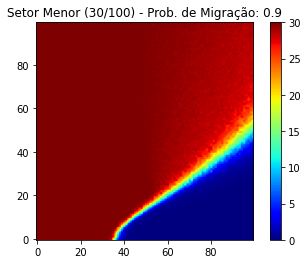

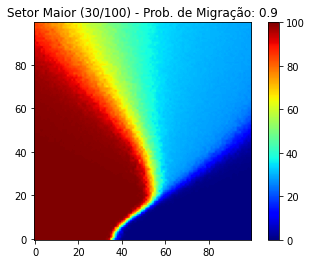

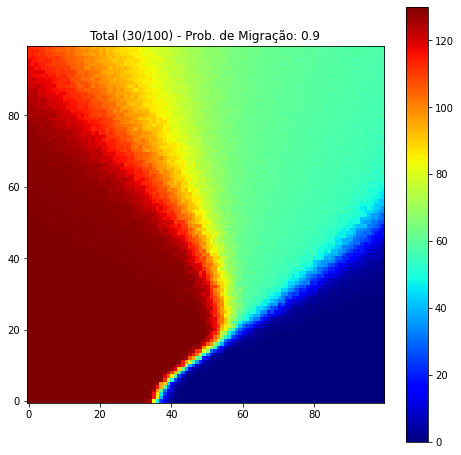

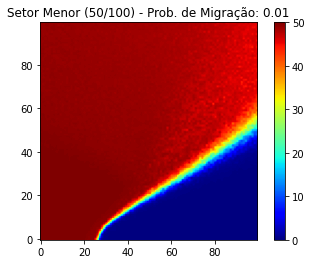

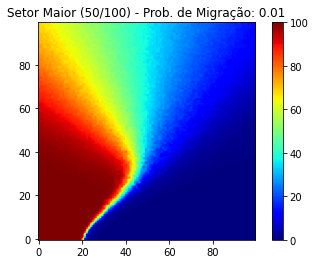

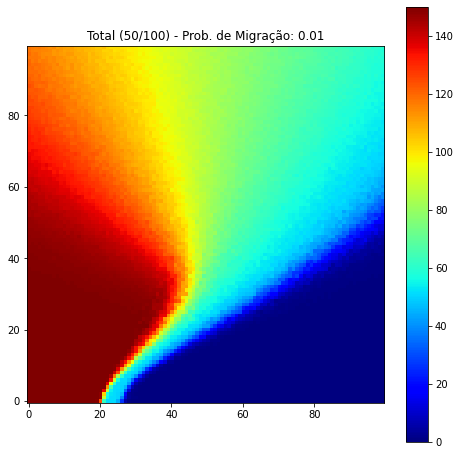

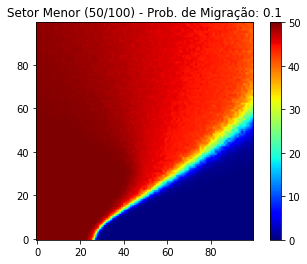

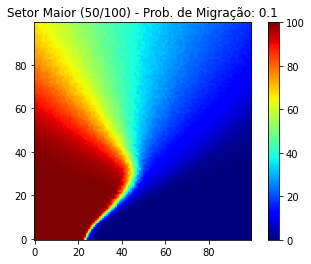

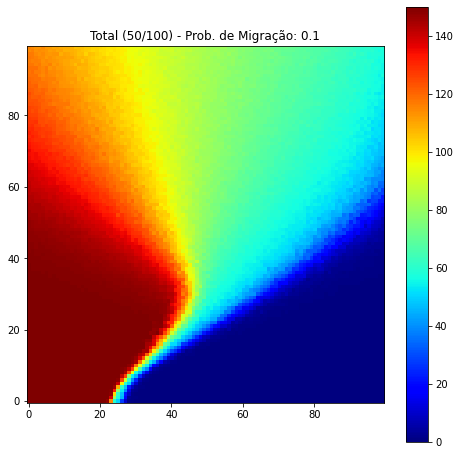

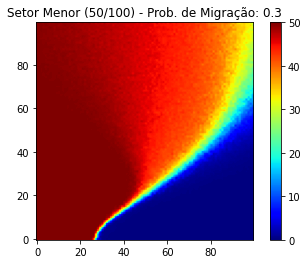

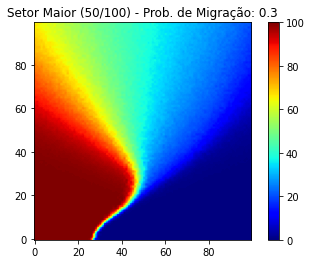

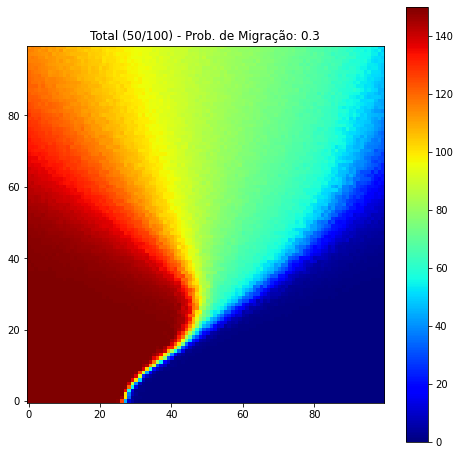

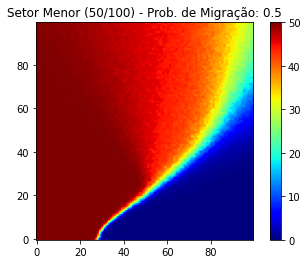

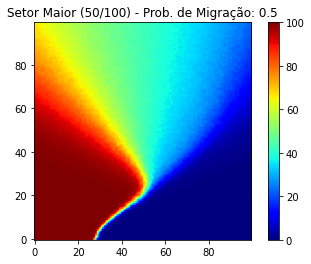

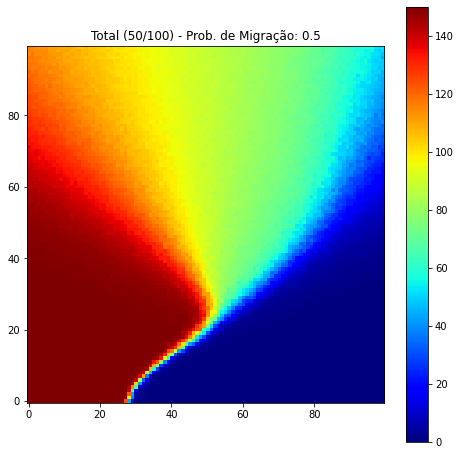

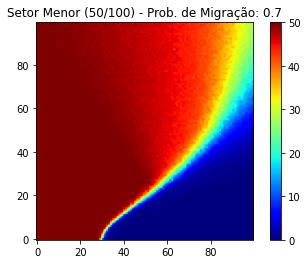

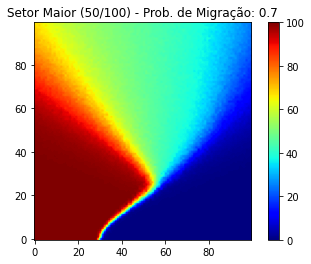

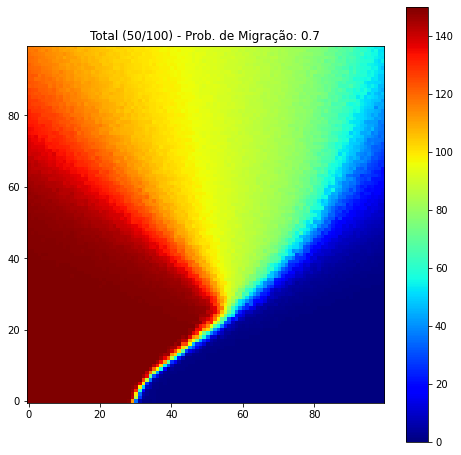

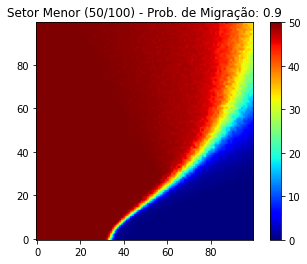

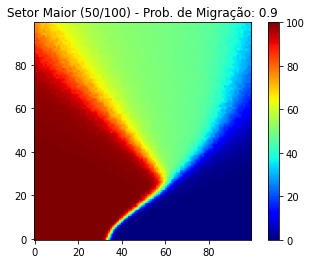

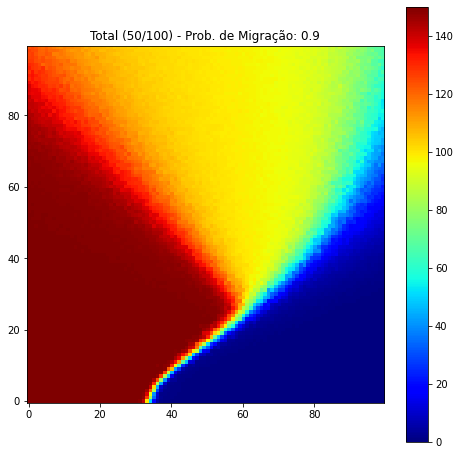

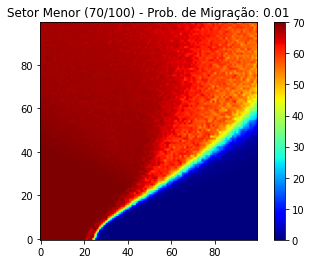

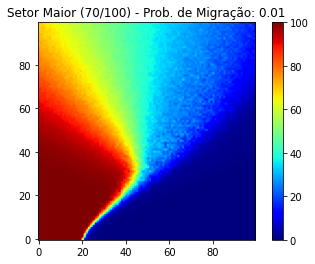

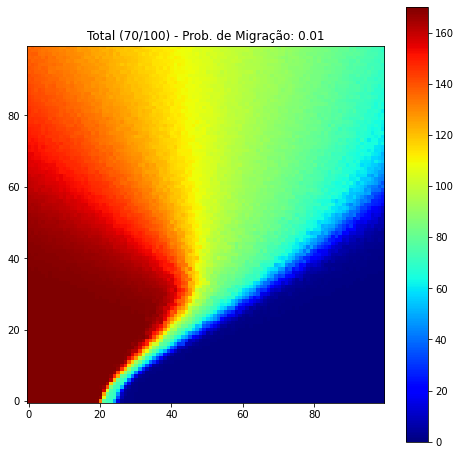

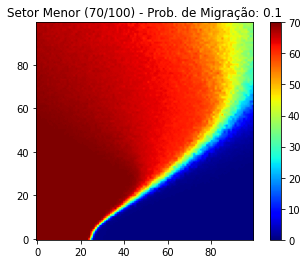

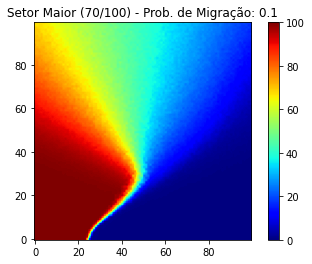

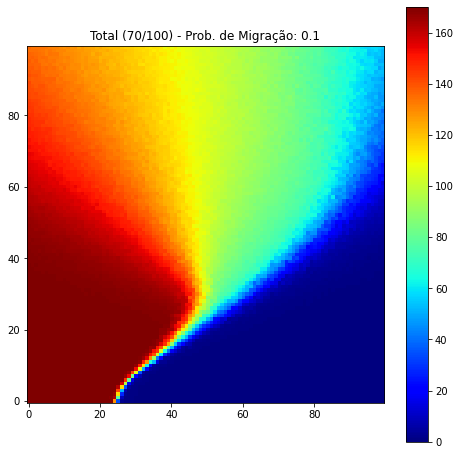

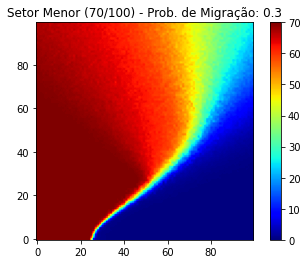

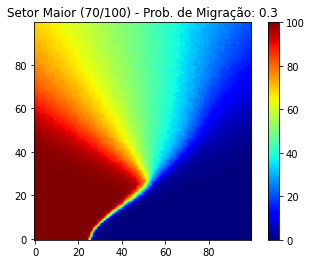

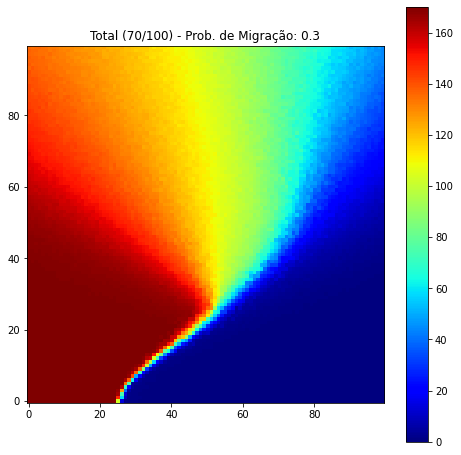

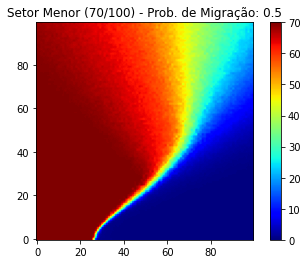

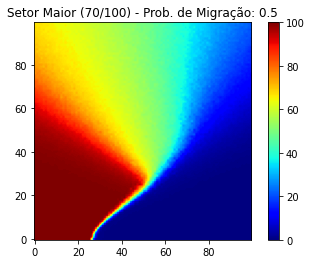

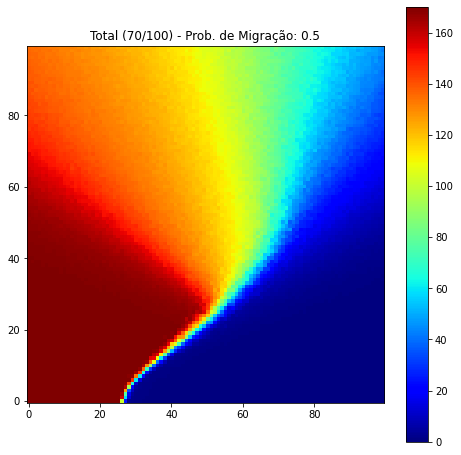

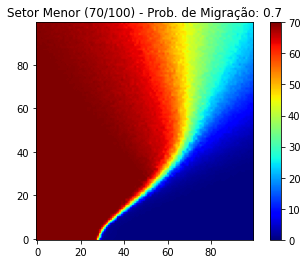

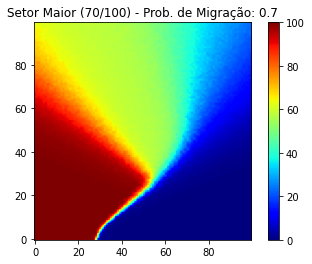

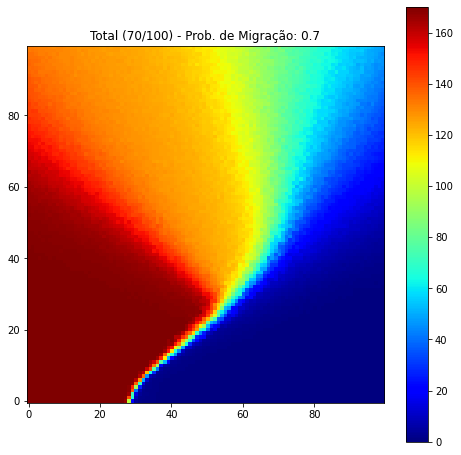

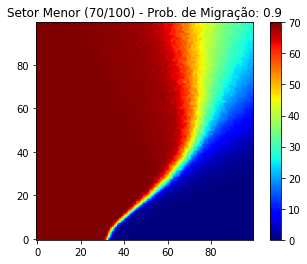

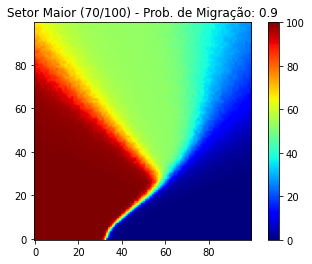

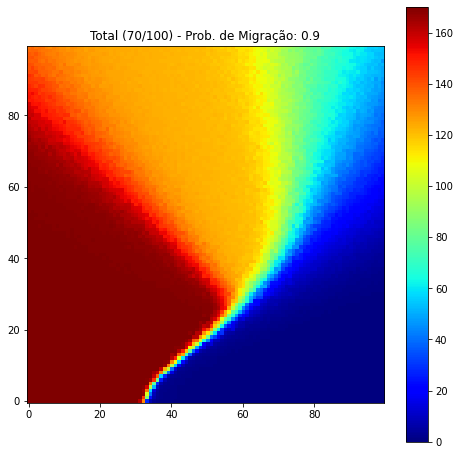

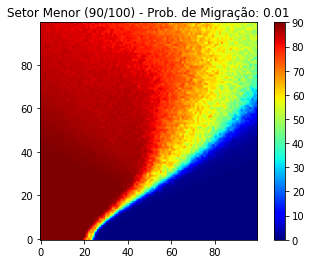

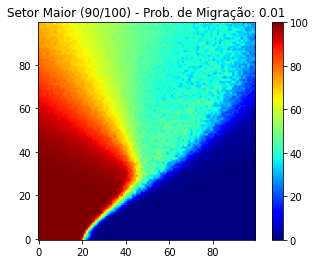

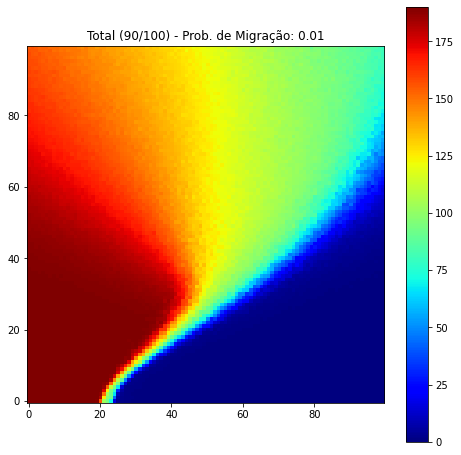

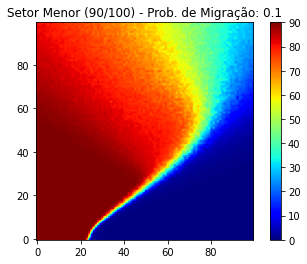

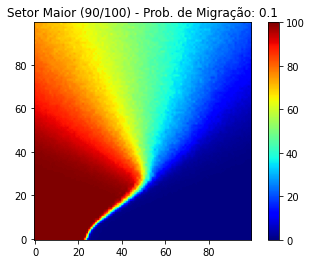

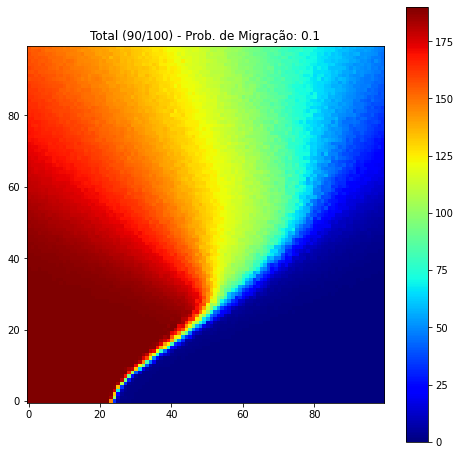

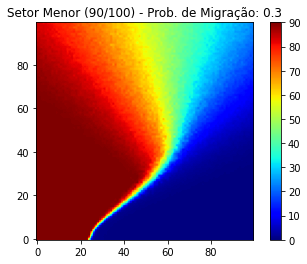

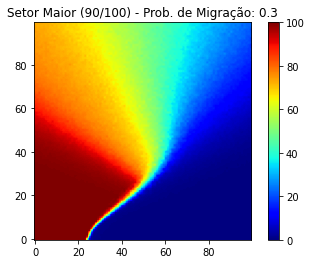

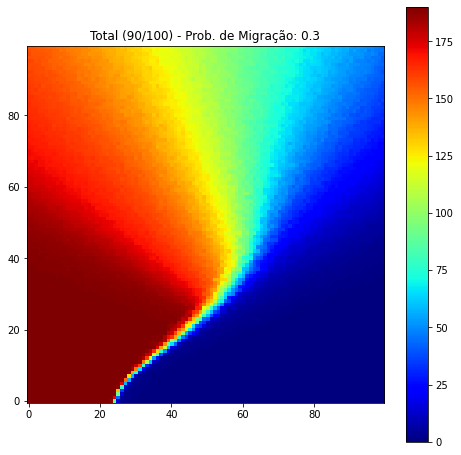

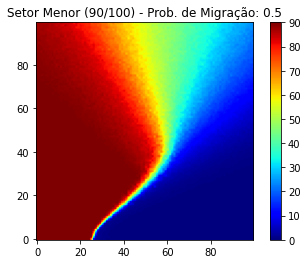

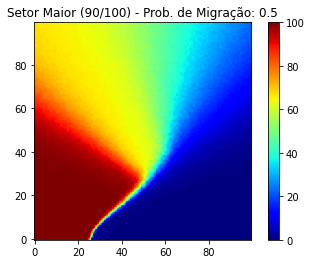

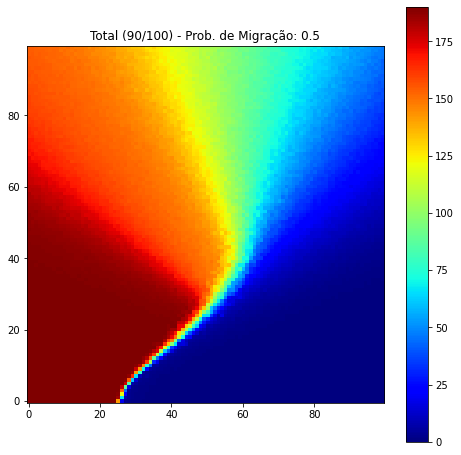

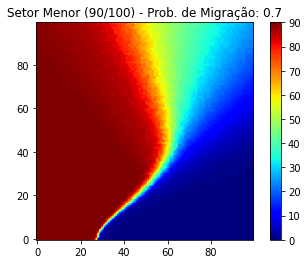

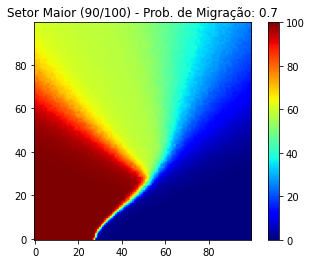

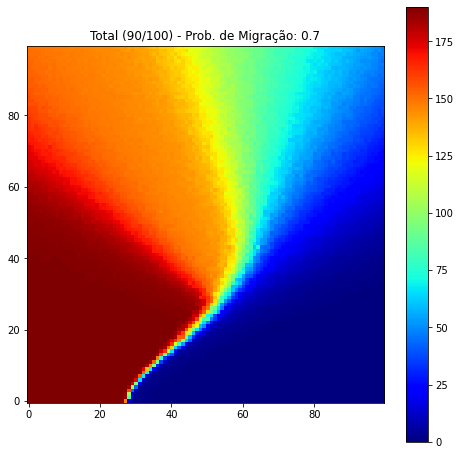

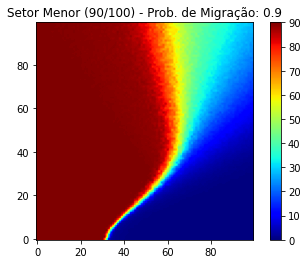

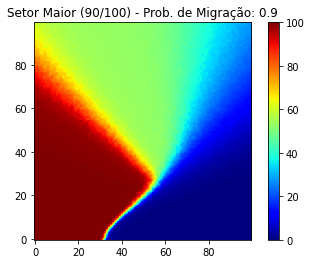

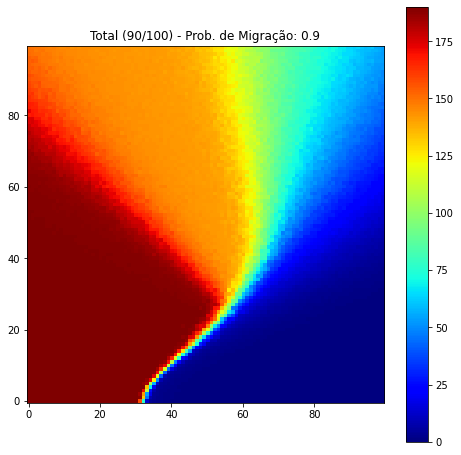

In [21]:
sizes = [10, 30, 50, 70, 90]
probs = [0.01, 0.1, 0.3, 0.5, 0.7, 0.9]
textos = ["001", "01", "03", "05", "07", "09"]
pontos = ["0.01", "0.1", "0.3", "0.5", "0.7", "0.9"]

for sector0_size in sizes:
    for j in range(len(textos)):
        migprobtexto = textos[j]
        ponto = pontos[j]

        f1 = open("simulate_riot_sectors_migration_exit_" + str(sector0_size) + "_" + migprobtexto + "_difsizes_0.txt", "r")
        f2 = open("simulate_riot_sectors_migration_exit_" + str(sector0_size) + "_" + migprobtexto + "_difsizes_1.txt", "r")
        f3 = open("simulate_riot_sectors_migration_exit_" + str(sector0_size) + "_" + migprobtexto + "_difsizes_total.txt", "r")

        h0 = np.zeros((100,100))
        h1 = np.zeros((100,100))
        h2 = np.zeros((100,100))

        for _ in range(10000):
            line = f1.readline()
            line = line.split()
            h0[int(line[0])][int(line[1])] = float(line[2])
            line = f2.readline()
            line = line.split()
            h1[int(line[0])][int(line[1])] = float(line[2])
            line = f3.readline()
            line = line.split()
            h2[int(line[0])][int(line[1])] = float(line[2])

        f1.close()
        f2.close()
        f3.close()
    
        plt.figure()
        plt.title("Setor Menor (" + str(sector0_size) + "/100) - Prob. de Migração: " + ponto)
        plt.imshow(h0, origin="lower",cmap="jet")
        plt.colorbar()
        plt.show()

        plt.figure()
        plt.title("Setor Maior (" + str(sector0_size) + "/100) - Prob. de Migração: " + ponto)
        plt.imshow(h1, origin="lower",cmap="jet")
        plt.colorbar()
        plt.show() 

        plt.figure(figsize=(8,8))
        plt.title("Total (" + str(sector0_size) + "/100) - Prob. de Migração: " + ponto)
        plt.imshow(h2, origin="lower",cmap="jet")
        plt.colorbar()
        plt.savefig("total_" + str(sector0_size) + "-100_" + ponto + ".png")
        plt.show() 